In [67]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta

#for models

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima

#for gridsearch
from sklearn.model_selection import GridSearchCV



#for Data
import yfinance as yf

#for Data Distribution
from scipy import stats

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


In [68]:
# Fetch historical data for the S&P 500
sp500_data = yf.download('^GSPC', start='2002-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


In [69]:
sp500_validation_set = yf.download('^GSPC', start='2023-01-02', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


Check NA Values

In [70]:
# Check for NaN values in the data
nan_values_df = sp500_data.isna().any()

print("NaN values in DataFrame:")
print(nan_values_df)

NaN values in DataFrame:
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [71]:
#Simple Moving Average:
#returns the dataframe with additional coumn of simple moving average
def calculate_sma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate SMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with SMA column added.
    """
    # Calculate SMA
    sma = df[column].rolling(window=window_size, min_periods=1).mean()
    
    # Create a DataFrame to store SMA
    df['SMA'] = sma
    df['SMA_signal'] = df['Close'] - df['SMA']
    return df

In [72]:
#Weighted Moving Average
def calculate_wma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Weighted Moving Average (WMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate WMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with WMA and WMA signal columns added.
    """
    # Generate the weights
    weights = np.arange(1, window_size + 1)
    data = df[column]
    
    # Calculate the WMA using convolution
    wma = data.rolling(window=window_size).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Create a DataFrame to store WMA
    df['WMA'] = wma
    
    # Add WMA signal column
    df['WMA_signal'] = df[column] - wma

    
    return df

In [73]:
#MACD
def calculate_macd(df: pd.DataFrame, short_window:int=12, long_window:int=26, signal_window:int=9, column: str = 'Adj Close') -> pd.DataFrame:
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        short_window (int): The short-term window size for the short EMA.
        long_window (int): The long-term window size for the long EMA.
        signal_window (int): The window size for the signal line EMA.

    Returns:
        DataFrame: DataFrame with additional columns for MACD and signal line.
    """
    # Calculate short-term EMA
    short_ema = df[column].ewm(span=short_window, min_periods=1, adjust=False).mean()
    
    # Calculate long-term EMA
    long_ema = df[column].ewm(span=long_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = short_ema - long_ema
    
    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    
    # Store MACD and signal line in the DataFrame
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    df['macd_signal'] = macd_line - signal_line
    return df

In [74]:
#Stochastic_oscillator
def calculate_stochastic_oscillator(df, k_fast_period=14, k_slow_period=3, d_slow_period=3, column: str = 'Adj Close'):
    """
    Calculate the Stochastic Oscillator and its corresponding moving averages (K and D lines).

    Parameters:
        df (DataFrame): DataFrame containing the data.
        k_fast_period (int): The period for the fast %K line.
        k_slow_period (int): The period for the slow %K line.
        d_slow_period (int): The period for the slow %D line.

    Returns:
        DataFrame: DataFrame with additional columns for %K_fast, %K_slow, %D_fast, and %D_slow.
    """
    # Calculate highest high and lowest low over the period
    HH = df['High'].rolling(window=k_fast_period).max()
    LL = df['Low'].rolling(window=k_fast_period).min()

    # Calculate %K_fast
    df['%K_fast'] = ((df[column] - LL) / 
                     (HH - LL)) * 100
    
    # Calculate %K_slow (smoothed %K_fast)
    df['%K_slow'] = df['%K_fast'].rolling(window=k_slow_period).mean()
    
    # Calculate %D_fast (3-day SMA of %K_slow)
    df['%D_fast'] = df['%K_slow'].rolling(window=d_slow_period).mean()
    
    # Calculate %D_slow (3-day SMA of %D_fast)
    df['%D_slow'] = df['%D_fast'].rolling(window=d_slow_period).mean()
    
    return df

In [75]:
#RSI
def calculate_rsi(df, window_size=14, column: str = 'Adj Close'):
    """
    Calculate the Relative Strength Index (RSI) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating RSI.

    Returns:
        DataFrame: DataFrame with an additional column for RSI.
    """
    # Calculate price changes
    delta = df[column].diff()
    
    # Define up and down moves
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    
    # Calculate the relative strength (RS)
    rs = gain / loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Store RSI in the DataFrame
    df['RSI'] = rsi
    
    return df

In [76]:
#WPR
def calculate_williams_percent_r(df, window=14, column: str = 'Adj Close'):
    """
    Calculate the Williams %R (WPR) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating WPR.

    Returns:
        DataFrame: DataFrame with an additional column for WPR.
    """
    # Calculate highest high and lowest low over the window
    highest_high = df['High'].rolling(window=window).max()
    lowest_low = df['Low'].rolling(window=window).min()
    
    # Calculate Williams %R
    wpr = ((highest_high - df[column]) / (highest_high - lowest_low)) * -100
    
    # Store WPR in the DataFrame
    df['WPR'] = wpr
    
    return df

In [77]:
#Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2, column: str = 'Adj Close'):
    """
    Calculate Bollinger Bands for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for the moving average.
        num_std_dev (int): The number of standard deviations for the bands.

    Returns:
        DataFrame: DataFrame with additional columns for Bollinger Bands.
    """
    # Calculate rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    # Store Bollinger Bands in the DataFrame
    df['Bollinger Upper'] = upper_band
    df['Bollinger Lower'] = lower_band
    df['Bollinger Diff'] = upper_band - lower_band
    
    return df

In [78]:
#On-Balance Volume (OBV)
def calculate_obv(df, column: str = 'Adj Close'):
    """
    Calculate On-Balance Volume (OBV) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.

    Returns:
        DataFrame: DataFrame with additional column for OBV.
    """
    obv_values = []
    prev_obv = 0

    for i in range(1, len(df)):
        if df[column].iloc[i] > df[column].iloc[i - 1]:
            obv = prev_obv + df['Volume'].iloc[i]
        elif df[column].iloc[i] < df[column].iloc[i - 1]:
            obv = prev_obv - df['Volume'].iloc[i]
        else:
            obv = prev_obv

        obv_values.append(obv)
        prev_obv = obv

    # Add initial OBV value as 0
    obv_values = [0] + obv_values

    # Store OBV in the DataFrame
    df['OBV'] = obv_values

    # Convert OBV column to int64
    df['OBV'] = df['OBV'].astype('int64')

    return df

In [79]:
#Average True Range (ATR)
def calculate_atr(df, period=14):
    """
    Calculate the Average True Range (ATR) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', and 'Close' columns representing high, low, and closing prices respectively.
        period (int): Number of periods for which to calculate the ATR (default is 14).

    Returns:
        DataFrame: DataFrame with 'ATR' column containing the calculated ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    
    # True Range (TR) calculation
    df['TR'] = df[['High', 'Low', 'Adj Close']].apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Adj Close']), abs(row['Low'] - row['Adj Close'])), axis=1)
    
    # ATR calculation
    df['ATR'] = df['TR'].rolling(period).mean()
    
    # Drop the TR column if not needed
    df.drop('TR', axis=1, inplace=True)
    
    return df

In [80]:
#rice Rate of Change (ROC)
def calculate_roc(df, n_periods=12, column='Adj Close'):
    """
    Calculate the Price Rate of Change (ROC) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'Adj Close' column representing closing prices.
        n_periods (int): Number of periods for which to calculate the ROC. # It can be anything such as 12, 25,
        or 200. Short-term trader traders typically use a smaller number while longer-term investors use a larger
        number.

    Returns:
        DataFrame: DataFrame with 'ROC' column containing the calculated ROC values.
    """
    close_prices = df[column]
    close_prices_shifted = close_prices.shift(n_periods)
    
    roc = ((close_prices - close_prices_shifted) / close_prices_shifted) * 100
    
    df['ROC'] = roc
    return df

In [81]:
#Money Flow Index - MFI
def calculate_mfi(df, period=14):
    """
    Calculate the Money Flow Index (MFI) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        period (int): Number of periods for which to calculate the MFI (default is 14).

    Returns:
        DataFrame: DataFrame with 'MFI' column containing the calculated MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Typical Price calculation
    tp = (high + low + close) / 3
    
    # Raw Money Flow calculation
    mf = tp * volume
    
    # Determine whether the typical price is higher or lower than the previous period
    tp_shifted = tp.shift(1)
    positive_flow = (tp > tp_shifted)
    negative_flow = (tp < tp_shifted)
    
    # Calculate positive and negative money flow
    positive_mf = positive_flow * mf
    negative_mf = negative_flow * mf
    
    # Calculate the Money Flow Ratio (MFR)
    mfr = positive_mf.rolling(window=period).sum() / negative_mf.rolling(window=period).sum()
    
    # Calculate the Money Flow Index (MFI)
    mfi = 100 - (100 / (1 + mfr))
    
    df['MFI'] = mfi
    
    return df

In [82]:
#chaikin_oscillator
def calculate_chaikin_oscillator(df, short_period=3, long_period=10):
    """
    Calculate the Chaikin Oscillator of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Adj Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        short_period (int): Number of periods for the short EMA (default is 3).
        long_period (int): Number of periods for the long EMA (default is 10).

    Returns:
        DataFrame: DataFrame with 'Chaikin_Oscillator' column containing the calculated Chaikin Oscillator values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Money Flow Multiplier calculation
    mfm = ((close - low) - (high - close)) / (high - low)
    
    # Money Flow Volume calculation
    mfv = mfm * volume
    
    # Accumulation/Distribution Line (ADL) calculation
    adl = mfv.cumsum()
    
    # Calculate the EMA for ADL
    ema_short = adl.ewm(span=short_period, min_periods=short_period, adjust=False).mean()
    ema_long = adl.ewm(span=long_period, min_periods=long_period, adjust=False).mean()
    
    # Calculate the Chaikin Oscillator
    chaikin_oscillator = ema_short - ema_long
    
    df['Chaikin_Oscillator'] = chaikin_oscillator
    
    return df

In [83]:
#Bulid the technical indicators: features
def technical_indicators(df):
    df = calculate_sma(df)
    df = calculate_wma(df)
    df = calculate_macd(df)
    df = calculate_rsi(df)
    df = calculate_stochastic_oscillator(df)
    df = calculate_bollinger_bands(df)
    df = calculate_williams_percent_r(df)
    df = calculate_obv(df)
    df = calculate_roc(df)
    df = calculate_atr(df)
    df = calculate_mfi(df)
    df = calculate_chaikin_oscillator(df)
    return df  

In [84]:
# Transformation Function
# Technical analysis indicators need to be rescaled before being fed to the models.
# The process is conducted using a version of min-max normalization technique which produces outputs in range from ‐1 to 1.
# This technique was chosen for two reasons: it is intuitive as the machine learning models produce output 
# variable that is also ranging from ‐1 to 1 and because it causes the input data to be more comparable. 
# X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

def feature_transform(df):
    """
    Transform all columns in the DataFrame as the following formula
    X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns transformed.
    """
    max_x = df.max()
    min_x = df.min()

    df_transformed = (df - min_x) / (max_x - min_x) * 2 - 1

    return df_transformed

In [85]:
#truncate the dataframe from the biggining so the walk forward splits will continue untill the last date
def truncate_before_wf(df, in_sample_size, out_sample_size):
    drop_index = (len(df) - in_sample_size) % out_sample_size
    return (df.iloc[drop_index:, :])

In [86]:
# Research employed dynamic estimation windows which means that the underlying parameters of the models 
# were periodically recalibrated to reflect current market behaviors. Observations from the beginning 
# of the available period were initially trimmed in order for the overall number of observations for
# each index to be easily divisible into equal subsets. Calibration of models’ parameters was conducted 
# on 200 trading day window (in-sample) and then model predictions were applied onto next 20 trading day
# window (out-of-sample). For each subsequent dynamic window iteration, in-sample and out-of-sample moved 
# by 20 trading days. 

def walk_forward_validation(df, in_sample_size, out_sample_size):
    """
    Perform walk-forward validation on a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        in_sample_size (int): Number of periods to use for in-sample data.
        out_sample_size (int): Number of periods to use for out-of-sample data.

    Returns:
        Tuple: Tuple containing lists of in-sample and out-of-sample data.
    """
    total_rows = len(df)
    n_subsets = (total_rows - in_sample_size) // out_sample_size
    splits = []
        
    for i in range(n_subsets):
        start_index = i * out_sample_size
        end_index = start_index + in_sample_size + out_sample_size
        
        if end_index > total_rows:
            break
        
        in_sample = df.iloc[start_index : start_index + in_sample_size]
        out_of_sample = df.iloc[start_index + in_sample_size : end_index]
        
        splits.append((in_sample, out_of_sample))
    return (splits)

In [87]:
# Compute the correlation coefficients between each feature and the return & print it

def correlation(df, target_name):

    correlation_with_target = np.abs(df.corrwith(df[target_name]))

    # Display the correlation coefficients
    print("Correlation with Log return:")
    print(correlation_with_target.sort_values(ascending=False))
    correlation_with_target.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation', )

In [88]:
#Thus far, we've only used a simple correlation statistic across the full time period. 
#This is a good place to start but, is a dangerous place to stop. Financial time series data suffers
# from non-stationarity and regime change, so a relationship which on average has existed may have been 
#wildly unstable over time.

#To check, we'll plot the rolling correlation of these selected features.

# Compute the rolling correlation for each pair of selected features
def rolling_correlation(df, target_name, window_size = 200):

    correlation_with_target_200 = df.rolling(window=window_size).corr(df[target_name])
    # Create traces for each feature
    traces = []
    for feature in df.columns:
        trace = go.Scatter(
            x=correlation_with_target_200.index,
            y=correlation_with_target_200[feature],
            mode='lines',
            name=feature
        )
        traces.append(trace)

    # Create layout for the plot
        layout = go.Layout(
        title='Rolling Correlation of Features with Log Return',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Rolling Correlation with Log Return'),
        hovermode='closest',
        autosize=True
    )

    # Create figure object
    fig = go.Figure(data=traces, layout=layout)

    # Show plot
    fig.show()

In [89]:
#Pair plot
def features_paiplot(df):
    pairplot = sns.pairplot(df, height=1.5)

    # Set the title
    pairplot.figure.suptitle('Pairplot of features', y=1.02)

    # Show the plot
    plt.show()

In [90]:
def count_outliers_iqr_df(df, k=1.5):
    """
    Count the number of outliers in each column of the DataFrame using the Interquartile Range (IQR) method.
    
    Parameters:
    - df: The input DataFrame.
    - k: The multiplier for the IQR. Typically set to 1.5 to 3.
    
    Returns:
    - A dictionary where keys are column names and values are the number of outliers detected in each column.
    """
    outliers_counts = {}
    for col in df.columns:
        data = df[col]
        quartile_1, quartile_3 = np.percentile(data, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (k * iqr)
        upper_bound = quartile_3 + (k * iqr)
        outliers = (data < lower_bound) | (data > upper_bound)
        outliers_counts[col] = np.sum(outliers)
    return outliers_counts


In [91]:
#Truncate NaN Data
def drop_nan(df):
    # Remove rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

In [92]:
#check distribution 
def check_distribution(df, column_name='Adj Close'):
    """
    Check the distribution of a column in a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column to check the distribution for (default is 'Adj Close').

    Returns:
        None (displays descriptive statistics and visualizations)
    """
    # Descriptive statistics
    print("Descriptive Statistics:")
    print(df[column_name].describe())

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

In [93]:
def is_normal(df, alpha=0.05):
    """
    Test if the data is normally distributed using Z-score.
    
    Parameters:
    - data: The input data array.
    - alpha: The significance level for the test.
    
    Returns:
    - True if the data is normally distributed, False otherwise.
    """
    normal_col = {}
    for col in df.columns:
        data = df[col]
        z_score, p_value = stats.normaltest(data)
        normal_col[col] = p_value > alpha
    return normal_col

Models Evaluation

In [94]:
def calculate_mape(actual, predicted):
    """
    Calculate Mean Absolute Percentage Error (MAPE)
    
    Args:
    actual: array-like, actual values
    predicted: array-like, predicted values
    
    Returns:
    mape: float, MAPE value
    """
    # Ensure both actual and predicted arrays have the same length
    if len(actual) != len(predicted):
        raise ValueError("Length of actual and predicted arrays must be the same.")
    

    # Calculate absolute percentage error for each observation
    abs_percentage_error = np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-10))
    
    # Calculate mean of absolute percentage errors
    mape = np.mean(abs_percentage_error) * 100
    
    return mape

In [95]:
def calculate_buy_and_hold_returns(df, column_to_diff='Predictions', column='Predicted Returns'):
    """
    Calculate returns from adjusted close prices of the bench mark buy and hold strategy.

    Parameters:
    df (DataFrame): DataFrame containing adjusted close prices.

    Returns:
    returns (DataFrame): DataFrame containing the calculated returns in df[column].
    """
    initial_value = df.iloc[0][column_to_diff]
    df[column] = (df[column_to_diff] - initial_value)/initial_value
    df = df.dropna()

    return df

In [96]:
def calculate_sharpe_ratio(df, column, risk_free_rate=0.0, annualized=True):
    """
    Calculate the Sharpe Ratio for the S&P 500 index.

    Parameters:
    - sp500_df: DataFrame containing historical S&P 500 index data with a 'Close' column.
    - risk_free_rate: Annualized risk-free rate of return (default is 0.0).
    - annualized: If True, return annualized Sharpe Ratio; if False, return non-annualized Sharpe Ratio (default is True).

    Returns:
    - sharpe_ratio: The calculated Sharpe Ratio.
    """
    # Calculate excess returns (returns above risk-free rate)
    excess_returns = df[column] - risk_free_rate / 252  # Assuming 252 trading days in a year

    # Calculate Sharpe Ratio
    sharpe_ratio = excess_returns.mean() / excess_returns.std()

    # Annualize Sharpe Ratio if required
    if annualized:
        sharpe_ratio *= (252 ** 0.5)

    return sharpe_ratio

In [97]:
def calculate_ir(stock_returns, benchmark_returns):
    """
    Calculate the Information Ratio (IR) for a stock compared to a benchmark.

    Parameters:
    - stock_returns: Array-like object containing historical returns of the stock.
    - benchmark_returns: Array-like object containing historical returns of the benchmark.

    Returns:
    - ir: The calculated Information Ratio.
    """
    
    # Step 1: Calculate excess returns
    excess_returns = stock_returns - benchmark_returns
    
    # Step 2: Calculate average excess return
    avg_excess_return = np.mean(excess_returns)
    
    # Step 3: Calculate standard deviation of excess returns
    std_excess_return = np.std(excess_returns)
    
    # Step 4: Calculate Information Ratio
    ir = avg_excess_return / std_excess_return
    
    return ir

In [98]:
def calculate_mdd(returns):
    """
    Calculate the Maximum Drawdown (MDD) of a time series of returns.

    Parameters:
    - returns: Array-like object containing historical returns.

    Returns:
    - max_drawdown: The calculated Maximum Drawdown.
    """
    
    # Calculate cumulative returns
    cum_returns = (1 + returns).cumprod()
    
    # Calculate the maximum value seen up to each point
    max_seen = cum_returns.cummax()
    
    # Calculate drawdowns
    drawdowns = (cum_returns - max_seen) / max_seen
    
    # Find the maximum drawdown
    max_drawdown = drawdowns.min()
    
    return max_drawdown

In [99]:
def calculate_accuracy(true_series, predicted_series):
    """
    Calculate the accuracy of a model that predicts buy, hold, or sell signals.

    Parameters:
    true_series (Series): Pandas Series containing true labels.
    predicted_series (Series): Pandas Series containing predicted labels.

    Returns:
    accuracy (float): Accuracy of the model.
    """
    if len(true_series) != len(predicted_series):
        raise ValueError("The lengths of true_series and predicted_series must be equal.")

    correct_predictions = sum(1 for true_label, predicted_label in zip(true_series,
                             predicted_series) if true_label == predicted_label)
    total_predictions = len(true_series)
    accuracy = correct_predictions / total_predictions

    return accuracy

Results Processing

In [100]:
def calculate_returns(df, column_to_diff='Predictions', column='Predicted Returns'):
    """
    Calculate returns from adjusted close prices.

    Parameters:
    df (DataFrame): DataFrame containing adjusted close prices.

    Returns:
    returns (DataFrame): DataFrame containing the calculated returns in df[column].
    """
    
    df[column] = df[column_to_diff].pct_change()
    df = df.dropna()

    return df

In [101]:
def calculate_quantiles(df, column='Predected Return', q1=0.25, q2=0.5, q3=0.75):
    """
    Calculate specified quantiles (percentiles) of a column in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - column: Name of the column for which quantiles are to be calculated (default is 'Predicted Return').
    - q1: The percentile to calculate for the first quartile (default is 0.25, corresponding to the 25th percentile).
    - q2: The percentile to calculate for the second quartile (default is 0.5, corresponding to the median).
    - q3: The percentile to calculate for the third quartile (default is 0.75, corresponding to the 75th percentile).

    Returns:
    - quantiles: A tuple containing the specified quantiles (Q1, Q2, Q3).
    """
    
    Q1 = df[column].quantile(q1)
    Q2 = df[column].quantile(q2)  # Median
    Q3 = df[column].quantile(q3)

    return (Q1, Q2, Q3)

In [102]:
def calculate_signal(df, return_column='Predicted Returns', signal_column='Predicted Signal', q1=None, q3=None):
    """
    Calculate trading signals based on specified quantiles of returns in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - return_column: Name of the column containing returns (default is 'Predicted Returns').
    - signal_column: Name of the column to store the calculated signals (default is 'Predicted Signal').
    - q1: The percentile to calculate for the first quartile (default is None, calculated as 0.25 quantile if not provided).
    - q3: The percentile to calculate for the third quartile (default is None, calculated as 0.75 quantile if not provided).

    Returns:
    - df: DataFrame with the added signal_column containing the calculated signals.
    """
    if q1 is None or q3 is None:
        q1 = df[return_column].quantile(0.25)
        q3 = df[return_column].quantile(0.75)

    df[signal_column] = 0  # Default signal

    df.loc[df[return_column] >= q3, signal_column] = 1
    df.loc[df[return_column] <= q1, signal_column] = -1

    return df

Data PreProcessing

In [103]:
#copy and add features
sp500 = sp500_data.copy()
sp500 = technical_indicators(sp500)
sp500_val = sp500_validation_set.copy()
sp500_val = technical_indicators(sp500_val)

In [104]:
#transform features
sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(feature_transform, axis=0)
sp500_val.iloc[:, 6:] = sp500_val.iloc[:, 6:].apply(feature_transform)

C:\Users\Nagham\AppData\Local\Temp\ipykernel_8504\65794321.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2002-01-02   -0.934138
2002-01-03   -0.932189
2002-01-04   -0.930082
2002-01-07   -0.931904
2002-01-08   -0.933658
                ...   
2022-12-23    0.780322
2022-12-27    0.776101
2022-12-28    0.771805
2022-12-29    0.775990
2022-12-30    0.771838
Name: OBV, Length: 5287, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Nagham\AppData\Local\Temp\ipykernel_8504\65794321.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2023-01-03   -0.722653
2023-01-04   -0.621227
2023-01-05   -0.710690
2023-01-06   -0.620535
2023-01-09   -0.719611
                ...   
2023-12-22    0.817068
2023-12-26    0.874833
2023-12-27    0.937986
2023-12-28    1.000000
2023-12-29

In [105]:
#drop NA
sp500 = sp500.dropna()
sp500_val = sp500_val.dropna()

In [41]:
#correlation before choosing features
#correlation(sp500, 'Adj Close')
#rolling_correlation(sp500, 'Adj Close')

# Step 1: Take the most strongly correlated feature and add it to our list of selected features. 
# Step 2: Take the second correlated feature and check to see if it's closely correlated 
# (neighboring in the clustermap) to any features already chosen.
# If no, add to the list. If yes, discard. 
# Step 3: Repeat this process until either (1) we've reached the target feature count,
# or (2) we've run out strongly correlated features.

# start here

In [ ]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [ ]:
check_distribution(sp500_d)

In [ ]:
#look at the correlated data:
#features_paiplot(sp500_d)
#correlation(sp500_d, 'Adj Close')
#rolling_correlation(sp500, 'Adj Close')


In [ ]:
print("Is data normal?", is_normal(sp500_d))

In [ ]:
outliers_counts = count_outliers_iqr_df(sp500_d)
print("Number of outliers in each column:")
print(outliers_counts)

In [ ]:
#choosing features:
chosen_features = ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']


In [ ]:
# In the context of regression tasks like this one (since SVR is a Support Vector Machine for regression),
# where the target variable is continuous (e.g., log returns), a model score less than 0 typically indicates 
# that the model is performing poorly and making predictions that are worse than simply using the mean or another
# basic statistical measure as the prediction for all samples.

Arima Model without Time Sieries Decomposition

In [ ]:
#clean the data from na values & pick the columns
data = sp500.copy()
data = drop_nan(data)
data = data.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [ ]:
splits = walk_forward_validation(data, 320, 80)

In [ ]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(data['Adj Close'], seasonal=False, trace=True)
print(model.summary())

Best Arima Model is ARIMA(2,1,2)

The data Splitted 80% - 20% - Walk Forward on test (the predictions added to the train)
The Method of WF as it was used for other Models WAS NOT USED HERE!!!
The Predictions were really bad when it was tried

In [ ]:
dataset_ex_df = data['Adj Close']
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [ ]:
class ARIMAModel:
    def __init__(self, order=(2, 1, 2)):
        self.order = order
        self.model = None
    
    def fit(self, history):
        self.model = ARIMA(history, order=self.order)
        self.model_fit = self.model.fit()
    
    def forecast(self):
        if self.model is None:
            raise Exception("Model not fitted yet. Call fit() method first.")
        return self.model_fit.forecast()

In [ ]:
dataset_ex_df = data['Adj Close']
# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = []

# Instantiate ARIMAModel
arima_model = ARIMAModel()

# Fit the model and make predictions
for t in range(len(test)):
    arima_model.fit(history)
    yhat = arima_model.forecast()[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

Arima Train set Results

In [ ]:
#Evaluate
mae = mean_absolute_error(test,predictions)
mse = mean_squared_error(test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
mape = mean_absolute_percentage_error(test,predictions)

# Visualize predictions vs. actual values
plt.scatter(test,predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

print(f'Mean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
# Plotting
# Create traces
trace1 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=test, mode='lines', name='Adjusted Close')
trace2 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=predictions, mode='lines', name='Adj_Close_diff')

# Create figure
fig = go.Figure()

# Add traces to figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(title='ARIMA Predictions vs Actual Values',
                  xaxis_title='Time',
                  yaxis_title='USD',
                  hovermode='x unified')

# Show plot
fig.show()

Arima Validation set results

In [ ]:
dataset_ex_df = sp500_val['Adj Close']
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
#size = int(len(X) * 0.8)
#train, test = X[0:size], X[size:len(X)]

# Walk-forward prediction
history = X[0]
predictions = list()
for t in range(len(X)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = X[t]
    history.append(obs)

In [ ]:
#Evaluate
mae = mean_absolute_error(X,predictions)
mse = mean_squared_error(X,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
mape = mean_absolute_percentage_error(test,predictions)
# Visualize predictions vs. actual values
plt.scatter(test,predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

print(f'Mean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
# Plotting
# Create traces
trace1 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=X, mode='lines', name='Adjusted Close')
trace2 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=predictions, mode='lines', name='Adj_Close_diff')

# Create figure
fig = go.Figure()

# Add traces to figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(title='ARIMA Predictions vs Actual Values',
                  xaxis_title='Time',
                  yaxis_title='USD',
                  hovermode='x unified')

# Show plot
fig.show()

Class For All Models

In [40]:
class TimeSeriesModels:
    def __init__(self, k=5, svr_kernel='rbf', C=1.0, gamma=0.1, degree=3, rf_n_estimators=100, rf_max_features=4, 
                 rf_criterion = 'squared_error', gbm_n_estimators=100, gbm_criterion='squared_error',
                 gbm_loss='squared_error', gbm_n_features='sqrt'):

        self.k = k
        self.svr_kernel = svr_kernel
        self.gamma = gamma
        self.degree = degree
        self.C = C
        self.rf_n_estimators = rf_n_estimators
        self.rf_max_features = rf_max_features
        self.rf_criterion = rf_criterion
        self.gbm_n_estimators = gbm_n_estimators
        self.gbm_criterion = gbm_criterion
        self.gbm_loss = gbm_loss
        self.gbm_n_features = gbm_n_features

        # Initialize models
        self.knn_model = KNeighborsRegressor(n_neighbors=self.k)
        self.svr_model = SVR(kernel=self.svr_kernel, gamma=self.gamma, degree=self.degree, C=self.C)
        self.rf_model = RandomForestRegressor(n_estimators=self.rf_n_estimators,
                         max_features=self.rf_max_features, criterion=self.rf_criterion, bootstrap=False, warm_start=True)
        self.gbm_model = GradientBoostingRegressor(n_estimators=self.gbm_n_estimators, 
                                                   criterion=self.gbm_criterion, loss=self.gbm_loss
                                                   ,max_features=self.gbm_n_features)
        self.lr_model = LinearRegression()

    def knn_fit(self, dfX, vY):
        self.knn_model.fit(dfX, vY)

    def svr_fit(self, dfX, vY):
        self.svr_model.fit(dfX, vY)

    def rf_fit(self, dfX, vY):
        self.rf_model.fit(dfX, vY)

    def gbm_fit(self, dfX, vY):
        self.gbm_model.fit(dfX, vY)
    
    def lr_fit(self, dfX, vY):
        self.lr_model.fit(dfX, vY)

    def knn_predict(self, dfX):
        return self.knn_model.predict(dfX)

    def svr_predict(self, dfX):
        return self.svr_model.predict(dfX)

    def rf_predict(self, dfX):
        return self.rf_model.predict(dfX)

    def gbm_predict(self, dfX):
        return self.gbm_model.predict(dfX)
    
    def lr_predict(self, dfX):
        return self.lr_model.predict(dfX)

    def knn_score(self, dfX, vY):
        return self.knn_model.score(dfX, vY)

    def svr_score(self, dfX, vY):
        return self.svr_model.score(dfX, vY)

    def rf_score(self, dfX, vY):
        return self.rf_model.score(dfX, vY)

    def gbm_score(self, dfX, vY):
        return self.gbm_model.score(dfX, vY)
    
    def lr_score(self, dfX, vY):
        return self.lr_model.score(dfX, vY)

    def knn_train(self, splits, col_drop):
        predictions = []
        
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.knn_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.knn_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def svr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.svr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.svr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def rf_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.rf_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.rf_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations

    def gbm_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.gbm_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.gbm_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def lr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.lr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.lr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def evaluate(self, y_true, y_pred):
        self.mae = mean_absolute_error(y_true, y_pred)
        self.mse = mean_squared_error(y_true, y_pred)
        self.rmse = np.sqrt(self.mse)
        self.r2 = r2_score(y_true, y_pred)
        self.mape = mean_absolute_percentage_error(y_true, y_pred)

        return (self.mae, self.mse, self.rmse, self.r2, self.mape)

# Walk Forward Analysis

In [137]:
data = sp500.copy()

data = drop_nan(data)
data = data.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [138]:
#Initalize the dataframe
sp500_d_WF_splits = data.copy()

#Allocate columns for results
sp500_d_WF_splits['Prediction_8'] = np.nan
sp500_d_WF_splits['Prediction_12'] = np.nan
sp500_d_WF_splits['Prediction_20'] = np.nan
sp500_d_WF_splits['Prediction_50'] = np.nan
sp500_d_WF_splits['Prediction_100'] = np.nan
sp500_d_WF_splits['Prediction_200'] = np.nan
sp500_d_WF_splits['Prediction_300'] = np.nan


In [139]:
#The model that was chosen to be perform the test with is Gbm
Model = TimeSeriesModels(gbm_n_estimators=100, gbm_criterion='squared_error', gbm_loss='squared_error', gbm_n_features=7)

In [141]:
def evaluate_model_performance(data, results_set, val_set, Model, num_splits, col_name='Adj Close'):
    result = {'R2': [], 'RMSE': [], 'R2_Val': [], 'RMSE_Val': []}
    
    for num_split in num_splits:
        x = len(data) // (num_split + 4)
        truncated_data = truncate_before_wf(data.copy(), 4 * x, x)
        splits = walk_forward_validation(truncated_data, 4 * x, x)
        
        predictions = Model.gbm_train(splits, col_name)
        train_column_name = f'Prediction_{num_split}'
        start_index = 4 * x
        results_set.iloc[start_index:start_index + len(predictions), results_set.columns.get_loc(train_column_name)] = predictions
        
        filtered_df = results_set.dropna(subset=[train_column_name])
        column1_values = filtered_df[col_name]
        column2_values = filtered_df[train_column_name]
        
        _, _, rmse, r2, _ = Model.evaluate(column1_values, column2_values)
        result['R2'].append(r2)
        result['RMSE'].append(rmse)
        
        # Evaluate on validation data
        feat_dfX = val_set.drop(columns=col_name)
        predictions_val = Model.gbm_predict(feat_dfX)
        #val_column_name = f'Val_with_{num_split}_splits'
        #val_set[val_column_name] = predictions_val
        
        _, _, rmse_val, r2_val, _ = Model.evaluate(val_set[col_name], predictions_val)
        result['R2_Val'].append(r2_val)
        result['RMSE_Val'].append(rmse_val)
    
    return result

In [142]:
dfX = sp500_val.copy()
dfX = dfX.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

# Example usage:
num_splits = [8, 12, 20, 50, 100, 200, 300]  # List of number of splits to evaluate
results = evaluate_model_performance(data, sp500_d_WF_splits, dfX, Model, num_splits)
# initiate a list to contain R2, RMSE values of each model
R2_training_set = results['R2']
RMSE = results['RMSE']

# initiate a list to contain R2, RMSE values of each model
R2_validation_set = results['R2_Val']
RMSE_validation_set = results['RMSE_Val']

# Plots

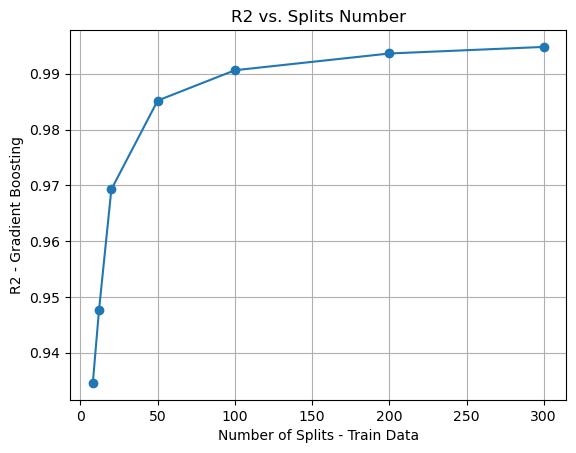

In [143]:
#Present results R2 train set
splits = [8, 12, 20, 50, 100, 200, 300]
# Plot list2 against list1
plt.plot(splits, R2_training_set, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Number of Splits - Train Data')
plt.ylabel('R2 - Gradient Boosting')
plt.title('R2 vs. Splits Number')

# Show plot
plt.grid(True)
plt.show()

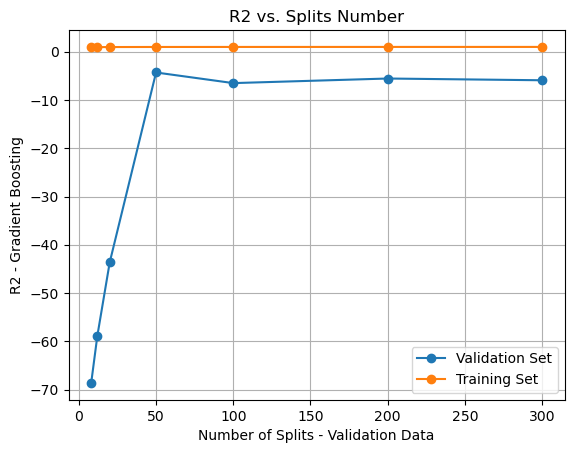

In [152]:
# Present results r2 val set
splits = [8, 12, 20, 50, 100, 200, 300]
# Plot R2 for validation set
plt.plot(splits, R2_validation_set, marker='o', linestyle='-', label='Validation Set')

# Plot R2 for training set
plt.plot(splits, R2_training_set, marker='o', linestyle='-', label='Training Set')

# Add labels and title
plt.xlabel('Number of Splits - Validation Data')
plt.ylabel('R2 - Gradient Boosting')
plt.title('R2 vs. Splits Number')

# Show legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

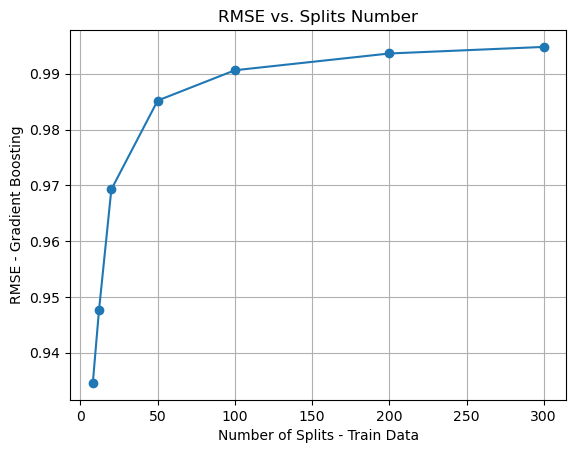

In [145]:
#RMSE for train set
splits = [8, 12, 20, 50, 100, 200, 300]

# Plot list2 against list1
plt.plot(splits, R2_training_set, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Number of Splits - Train Data')
plt.ylabel('RMSE - Gradient Boosting')
plt.title('RMSE vs. Splits Number')

# Show plot
plt.grid(True)
plt.show()

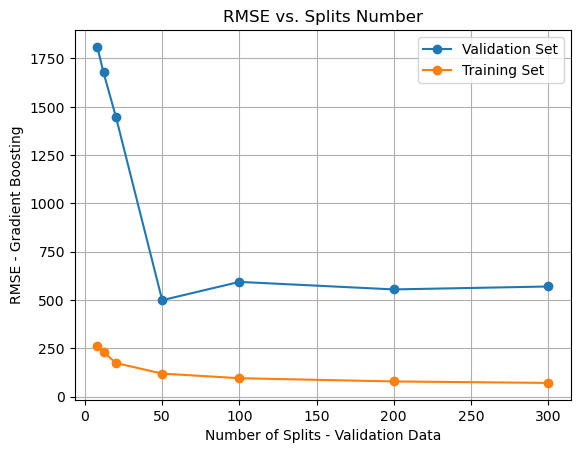

In [150]:
# Present results r2=mse val set
splits = [8, 12, 20, 50, 100, 200, 300]
# Plot RMSE for validation set
plt.plot(splits, RMSE_validation_set, marker='o', linestyle='-', label='Validation Set')

# Plot RMSE for training set
plt.plot(splits, RMSE, marker='o', linestyle='-', label='Training Set')

# Add labels and title
plt.xlabel('Number of Splits - Validation Data')
plt.ylabel('RMSE - Gradient Boosting')
plt.title('RMSE vs. Splits Number')

# Show legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [146]:
# Create an empty figure
fig = go.Figure()
df_columns = ['Adj Close', 'Prediction_8', 'Prediction_12', 'Prediction_20', 'Prediction_50', 'Prediction_100', 'Prediction_200', 'Prediction_300']
# Iterate over columns and add each one to the figure with a different color
for col in df_columns:
    fig.add_trace(go.Scatter(x=sp500_d_WF_splits.index, y=sp500_d_WF_splits[col], mode='lines', name=col))

# Update layout
fig.update_layout(
    title="Prediction with Gradient Boosting Model, with different number of data splits",
    xaxis_title="Time",
    yaxis_title="Value",
    legend=dict(title="Columns")
)

# Show the plot
fig.show()

# Models Comparision

Data to perform optimization

In [159]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [160]:
#Split the data
sp500_d = truncate_before_wf(sp500_d, 400, 100)
splits = walk_forward_validation(sp500_d, 400, 100)

# Adjust the predected df index (should cut the first unpredected 1300)
index_dropped = 400
index_predict = 100

Grid Search SVR Optimization

In [161]:
lC      = [1, 10, 100]
lKernel = ['poly', 'rbf','linear']
lgamma      = ['scale', 'auto', 0.1, 0.01, 0.001]
ldegree = [3, 4, 5, 6, 7, 8, 9]

In [162]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(lKernel) * len(lC) * len(lgamma) * len(ldegree)
dData   = {'kernel': [], 'C': [], 'gamma':[], 'degree':[]}

for ii, kernel in enumerate(lKernel):
    for jj, paramC in enumerate(lC):
        for kk, gamma in enumerate(lgamma):
            for cc, degree in enumerate(ldegree):
                dData['kernel'].append(kernel)
                dData['C'].append(paramC)
                dData['gamma'].append(gamma)
                dData['degree'].append(degree)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)


In [163]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    kernel    = dfModelScore.loc[ii, 'kernel']
    paramC          = dfModelScore.loc[ii, 'C']
    gamma          = dfModelScore.loc[ii, 'gamma']
    degree          = dfModelScore.loc[ii, 'degree']


    print(f'Processing model {ii + 1:03d} out of {numComb}')

    Model = TimeSeriesModels(svr_kernel=kernel, C=paramC, gamma=gamma, degree=degree)
    predictions = Model.svr_train(splits, 'Adj Close')
    
    # Calculate evaluation metrics
    #the calculation for eaach model was performed on the last split of the walk forward
    mae, mse, rmse, r2, mape = Model.evaluate(vY[-index_predict:], predictions[-index_predict:])
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

Processing model 001 out of 315
Processing model 002 out of 315
Processing model 003 out of 315
Processing model 004 out of 315
Processing model 005 out of 315
Processing model 006 out of 315
Processing model 007 out of 315
Processing model 008 out of 315
Processing model 009 out of 315
Processing model 010 out of 315
Processing model 011 out of 315
Processing model 012 out of 315
Processing model 013 out of 315
Processing model 014 out of 315
Processing model 015 out of 315
Processing model 016 out of 315
Processing model 017 out of 315
Processing model 018 out of 315
Processing model 019 out of 315


Find Best Model Score or SVR Kernel

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'RMSE', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['MeanScore'].idxmin()

# Find the index of the model with the higher r2
best_model_index_r2 = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['kernel', 'C', 'gamma', 'degree']]

# Get the parameters of the best model
best_model_params_r2 = dfModelScore.loc[best_model_index_r2, ['kernel', 'C', 'gamma', 'degree']]


# Print the parameters of the best model
print("Best Model Parameters - lowest mean of (MAE, RMSE, MAPE):")
print(best_model_params)

# Print the parameters of the best model
print("\n\n Best Model Parameters - Higher R2:")
print(best_model_params_r2)

Train the best SVR Model

In [ ]:
Model = TimeSeriesModels(svr_kernel='linear', C=100, gamma='scale', degree=3)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
predictions = Model.svr_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions

In [ ]:
# Initialize an empty list to store predictions
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]

# Calculate evaluation metrics
mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)

# Update the 'R2' column in dfModelScore with the calculated R2 score
dfModelScore.loc['MAE'] = mae
dfModelScore.loc['MSE'] = mse
dfModelScore.loc['RMSE'] = rmse
dfModelScore.loc['R2'] = r2
dfModelScore.loc['MAPE'] = mape

KNN Optimization

In [ ]:
dData   = {'K': []}

#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for kk in range(10):
    print(f'Processing model {kk + 1:03d} out of {10}')

    Model = TimeSeriesModels(k=kk + 1)
    predictions = Model.knn_train(splits, 'Adj Close')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY[-index_predict:], predictions[-index_predict:])
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[kk, 'k'] = kk + 1
    dfModelScore.loc[kk, 'MAE'] = mae
    dfModelScore.loc[kk, 'MSE'] = mse
    dfModelScore.loc[kk, 'RMSE'] = rmse
    dfModelScore.loc[kk, 'R2'] = r2
    dfModelScore.loc[kk, 'MAPE'] = mape

#===============================================================#

Find best KNN Model

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'RMSE', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['MeanScore'].idxmin()

# Find the index of the model with the higher r2
best_model_index_r2 = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['k']]

# Get the parameters of the best model
best_model_params_r2 = dfModelScore.loc[best_model_index_r2, ['k']]


# Print the parameters of the best model
print("Best Model Parameters - lowest mean of (MAE, RMSE, MAPE):")
print(best_model_params)

# Print the parameters of the best model
print("Best Model Parameters - Higher R2:")
print(best_model_params_r2)

Train the best KNN Model

In [ ]:
Model = TimeSeriesModels(k=9)

# Initialize an empty list to store predictions
predictions = Model.knn_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions

LinearRegressor - no hyperparameters

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]

predictions = Model.lr_train(splits, 'Adj Close')

# Calculate evaluation metrics
mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)

# Update the 'R2' column in dfModelScore with the calculated R2 score
dfModelScore.loc['MAE'] = mae
dfModelScore.loc['MSE'] = mse
dfModelScore.loc['RMSE'] = rmse
dfModelScore.loc['R2'] = r2
dfModelScore.loc['MAPE'] = mape

#===============================================================#

Random Forest Optimization

In [ ]:
m_features = ['sqrt', 'log2', 4, 5, 6, 7]
#criterion = ['squared_error', 'MAE']
criterion = ['squared_error']
n_estimators = [10, 100, 150, 200] #number of threes in the forest (100 default)

In [ ]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(m_features) * len(criterion) * len(n_estimators)
dData   = {'max_features': [], 'criterion': [], 'n_estimators':[]}

for ii, feature in enumerate(m_features):
    for jj, cri in enumerate(criterion):
        for kk, est in enumerate(n_estimators):
            dData['max_features'].append(feature)
            dData['criterion'].append(cri)
            dData['n_estimators'].append(est)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions 
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    rf_n_feature = dfModelScore.loc[ii, 'max_features']
    rf_criterion = dfModelScore.loc[ii, 'criterion']
    rf_n_est = dfModelScore.loc[ii, 'n_estimators']

    print(f'Processing model {ii + 1:03d} out of {numComb}')
    Model = TimeSeriesModels(rf_n_estimators=rf_n_est, rf_max_features=rf_n_feature ,rf_criterion = rf_criterion)
    predictions = Model.rf_train(splits, 'Adj Close')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

#===============================================================#

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'RMSE', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['MeanScore'].idxmin()

# Find the index of the model with the higher r2
best_model_index_r2 = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['max_features', 'criterion', 'n_estimators']]

# Get the parameters of the best model
best_model_params_r2 = dfModelScore.loc[best_model_index_r2, ['max_features', 'criterion', 'n_estimators']]


# Print the parameters of the best model
print("Best Model Parameters - lowest mean of (MAE, RMSE, MAPE):")
print(best_model_params)

# Print the parameters of the best model
print("Best Model Parameters - Higher R2:")
print(best_model_params_r2)

In [ ]:
dfModelScore.describe()

Train the best Random Forest model

In [ ]:
Model = TimeSeriesModels(rf_n_estimators=150, rf_max_features=7)

# Initialize an empty list to store predictions 
predictions = Model.rf_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions


Gradient Boosting Optimization

In [ ]:
L_loss = ['squared_error', 'absolute_error', 'huber']
L_criterion = ['friedman_mse', 'squared_error']
L_n_estimators = [100, 150, 200] #number of threes in the forest (100 default)
L_m_features = ['sqrt', 'log2', 5, 7]

In [ ]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(L_loss) * len(L_criterion) * len(L_n_estimators) *len(L_m_features)
dData   = {'loss': [], 'criterion': [], 'n_estimators':[], 'm_features':[]}

for ii, lss in enumerate(L_loss):
    for jj, cri in enumerate(L_criterion):
        for kk, est in enumerate(L_n_estimators):
            for kk, feature in enumerate(L_m_features):
                dData['loss'].append(lss)
                dData['criterion'].append(cri)
                dData['n_estimators'].append(est)
                dData['m_features'].append(feature)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    gbm_lo = dfModelScore.loc[ii, 'loss']
    gbm_cri = dfModelScore.loc[ii, 'criterion']
    gbm_n_est = dfModelScore.loc[ii, 'n_estimators']
    gbm_feat = dfModelScore.loc[ii, 'm_features']

    print(f'Processing model {ii + 1:03d} out of {numComb}')
    Model = TimeSeriesModels(gbm_n_estimators=gbm_n_est, gbm_criterion=gbm_cri, gbm_loss=gbm_lo
                                                   ,gbm_n_features=gbm_feat)
    predictions = Model.gbm_train(splits, 'Adj Close')

    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

#===============================================================#

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'RMSE', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['MeanScore'].idxmin()

# Find the index of the model with the higher r2
best_model_index_r2 = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['loss', 'criterion', 'n_estimators', 'm_features']]

# Get the parameters of the best model
best_model_params_r2 = dfModelScore.loc[best_model_index_r2, ['loss', 'criterion', 'n_estimators', 'm_features']]


# Print the parameters of the best model
print("Best Model Parameters - lowest mean of (MAE, RMSE, MAPE):")
print(best_model_params)

# Print the parameters of the best model
print("Best Model Parameters - Higher R2:")
print(best_model_params_r2)

Train Gradient Boosting Model

In [ ]:
Model = TimeSeriesModels(gbm_n_estimators=100, gbm_criterion='squared_error', 
                         gbm_loss='squared_error', gbm_n_features=7)
predictions = Model.gbm_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions


# Results Visualization

In [ ]:
# Visualize predictions vs. actual values
plt.scatter(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

mae = mean_absolute_error(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
mse = mean_squared_error(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
rmse = np.sqrt(mse)
r2 = r2_score(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
mape = mean_absolute_percentage_error(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj Close'
feature2 = 'Predictions'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Model - Adjusted Close Vs. Predictions on train dataset - WF 200,50 (100 splits)',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

Convert Predected values to returns

In [ ]:
analyze = sp500_d_includes_results.copy()
#Calculate returns
analyze = calculate_returns(analyze, 'Adj Close', 'Returns')
analyze = calculate_returns(analyze, 'Predictions', 'Predicted Returns')

#calculate buy and sell signals
analyze = calculate_signal(analyze, 'Returns', 'Signal')
analyze = calculate_signal(analyze, 'Predicted Returns', 'Predicted Signal')

Check the distribution of the returns

In [ ]:
check_distribution(analyze, 'Predicted Returns')

In [ ]:
feature1 = 'Returns'
feature2 = 'Predicted Returns'

# Create line plot
fig = go.Figure()

# Add line plot for feature1
fig.add_trace(go.Scatter(
    x=analyze.index,  # Assuming the index represents x-axis values
    y=analyze[feature1],
    mode='lines',
    name=feature1
))

# Add line plot for feature2
fig.add_trace(go.Scatter(
    x=analyze.index,  # Assuming the index represents x-axis values
    y=analyze[feature2],
    mode='lines',
    name=feature2
))

# Calculate quartiles for feature1
q1_feature1 = analyze[feature1].quantile(0.25)
q3_feature1 = analyze[feature1].quantile(0.75)

# Calculate quartiles for feature2
q1_feature2 = analyze[feature2].quantile(0.25)
q3_feature2 = analyze[feature2].quantile(0.75)

# Add horizontal lines for quartiles for feature1
fig.add_hline(y=q1_feature1, line_dash="dash", line_color="green", annotation_text=f'{feature1} Q1: {q1_feature1}', annotation_position="bottom right")
fig.add_hline(y=q3_feature1, line_dash="dash", line_color="orange", annotation_text=f'{feature1} Q3: {q3_feature1}', annotation_position="top right")

# Add horizontal lines for quartiles for feature2
fig.add_hline(y=q1_feature2, line_dash="dash", line_color="black", annotation_text=f'{feature2} Q1: {q1_feature2}', annotation_position="bottom left")
fig.add_hline(y=q3_feature2, line_dash="dash", line_color="white", annotation_text=f'{feature2} Q3: {q3_feature2}', annotation_position="top left")

# Customize layout
fig.update_layout(
    title='Model - Predicted Returns Vs. Returns - WF 200,20',
    xaxis=dict(title='Time Index'),  # Customize x-axis label
    yaxis=dict(title='Returns'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

Chose a bench Mark

In [ ]:
#calculate bench mark buy and hold returns
analyze = calculate_buy_and_hold_returns(analyze, 'Adj Close', 'Returns BH')

Sharpe Ratio / Information Ratio / Maximum Drowdown: returns vs predected

In [ ]:
sharp_true = calculate_sharpe_ratio(analyze['Returns'])
sharp_pred = calculate_sharpe_ratio(analyze['Predicted Returns'])
sharp_BH = calculate_sharpe_ratio(analyze['Returns BH'])
ir_true = calculate_ir(analyze['Returns'],  analyze['Returns BH'])
ir_pred = calculate_ir(analyze['Predicted Returns'],  analyze['Returns BH'])
ir_BH = calculate_ir(analyze['Returns BH'],  analyze['Returns BH'])
mdd_true = calculate_mdd(analyze['Returns'])
mdd_pred = calculate_mdd(analyze['Predicted Returns'])
mdd_BH = calculate_mdd(analyze['Returns BH'])

print(sharp_true, sharp_pred, sharp_BH, ir_true, ir_pred, ir_BH, mdd_true, mdd_pred, mdd_BH)

Calculate Accuracy

In [ ]:
train_accuracy =

# Validation Set

In [ ]:
#copy the validation set
dfX = sp500_val.copy()

#drop the Adjusted Close feature
feat_dfX = dfX.drop(columns='Adj Close')

Choose the Model

In [ ]:
dfX['Predicted Adj Close'] = Model.svr_predict(feat_dfX)

In [ ]:
#Calculate returns
dfX = calculate_returns(dfX, 'Adj Close', 'Returns')
dfX = calculate_returns(dfX, 'Predicted Adj Close', 'Predicted Returns')

#calculate buy and sell signals
dfX = calculate_signal(dfX, 'Predicted Returns', 'Predicted Signal')
dfX = calculate_signal(dfX, 'Returns', 'Signal')

#calculate model accuracy
accuracy = calculate_accuracy(dfX['Signal'], dfX['Predicted Signal'])

In [ ]:
#Plot the predected Adjucted Close Vs Adj Close
feature1 = 'Adj Close'
feature2 = 'Predicted Adj Close'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Model - Adjusted Close Vs. Predictions',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

In [ ]:
#show returns and quantiles
feature1 = 'Returns'
feature2 = 'Predicted Returns'

# Create line plot
fig = go.Figure()

# Add line plot for feature1
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature1],
    mode='lines',
    name=feature1
))

# Add line plot for feature2
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature2],
    mode='lines',
    name=feature2
))

# Calculate quartiles for feature1
q1_feature1 = dfX[feature1].quantile(0.25)
q3_feature1 = dfX[feature1].quantile(0.75)

# Calculate quartiles for feature2
q1_feature2 = dfX[feature2].quantile(0.25)
q3_feature2 = dfX[feature2].quantile(0.75)

# Add horizontal lines for quartiles for feature1
fig.add_hline(y=q1_feature1, line_dash="dash", line_color="green", annotation_text=f'{feature1} Q1: {q1_feature1}', annotation_position="bottom right")
fig.add_hline(y=q3_feature1, line_dash="dash", line_color="orange", annotation_text=f'{feature1} Q3: {q3_feature1}', annotation_position="top right")

# Add horizontal lines for quartiles for feature2
fig.add_hline(y=q1_feature2, line_dash="dash", line_color="black", annotation_text=f'{feature2} Q1: {q1_feature2}', annotation_position="bottom left")
fig.add_hline(y=q3_feature2, line_dash="dash", line_color="white", annotation_text=f'{feature2} Q3: {q3_feature2}', annotation_position="top left")

# Customize layout
fig.update_layout(
    title='Model - Predicted Returns Vs. Returns - WF 200,20',
    xaxis=dict(title='Time Index'),  # Customize x-axis label
    yaxis=dict(title='Returns'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()